# Finding Cu crystal ground state via the Augmented Plane method

This project is adapted from Thijssen.

## Theory

Bloch's theorem constrains the form of eigenstates in a crystal. A simple basis for an eigenstate labelled by $\vec{k}$ is the plane wave basis:

$$\psi_{\vec{k} + \vec{K}} = e^{i(\vec{k} + \vec{K})\cdot\vec{r}}\tag{1}$$

Variational methods can then be used to deduce the eigenstate.

However, due to the size of the potential near the nuclei, this basis is inefficient. A way round this problem is to us the Muffin approximation. Near the nuclei the solution is solved exactly and then related to the plane waves via boundary conditions at some radius $R$. The variational method can then be applied efficiently to this basis. For a full description of the theory see Thijssen.

WHat is it being solved for (single electron?)

## Implementation

The variational equations are not linear, making the problem much harder to solve. In this implementation a brute force approach has been followed, the energy found for a given $\vec{k}$ is where the determinant changes sign.

The solution near the nuclei is a hard problem to solve. In the project, a 






In [363]:
import numpy as np
from scipy import special as sp
import matplotlib.pyplot as plt

In [364]:
#constants
a = 6.822 
R = 2.5
vol = 3*(a**3)/4

l_max = 2*(2+1) +3
nLim = 2 

#define recipricol lattice vectors 
b1 = 2*np.pi*np.array([-1,1,1])/a
b2 = 2*np.pi*np.array([1,-1,1])/a
b3 = 2*np.pi*np.array([1,1,-1])/a
Ks =[l*b1 + m*b2 + n*b3 for l in range(-nLim,nLim+1) for m in range(-nLim,nLim+1) for n in range(-nLim,nLim+1)]



In [365]:
#generate A
A = np.empty([len(Ks),len(Ks)])

for i,K_i in enumerate(Ks):
    for j,K_j in enumerate(Ks):
        kDiff = np.linalg.norm(K_i-K_j)
        if kDiff == 0:
            A[i,j] = 1
        else:
            A[i,j] = -4*np.pi*(R**2)*sp.spherical_jn(1,kDiff*R)/(vol*kDiff)





In [366]:
def iterateRK4(t_n,y_n,h,f):
    """
    Iterates by RK4 method.
    """
    k_1 = f(t_n, y_n)
    k_2 = f(t_n + h/2, y_n + h*k_1/2)
    k_3 = f(t_n + h/2, y_n + h*k_2/2)
    k_4 = f(t_n + h, y_n + h*k_3)

    return y_n + h*(k_1 + 2*k_2 + 2*k_3 + k_4)/6

def intialCond(l,r_0):
    #from small r solution to radial schrodinger eq, remember its u not R
    return np.array([r_0**(l+1),(l+1)*r_0**l])

r_c = 0.25*2
def V(r):
    return -13.201*np.exp(-r/r_c)/r 

n = 10
def getfRadial(l,E):
    def f(r,y):
        u = y[0]
        p = y[1] #p = du/dr
        f_u = p
        f_p = (l*(l+1)/(r**2) - 2*E + 2*V(r))*u
        return np.array([f_u,f_p])
    return f
        
r_0 = 0.05
h = 0.05
lim = 0.1

def getRatio(l,E):
    rs = [r_0]
    ys = [intialCond(l,r_0)]
    for i in range(int((R - r_0)/h)):
        rs.append(rs[-1]+h)
        ys.append(iterateRK4(rs[-1],ys[-1],h,getfRadial(l,E)))

    return ys[-1][1]/ys[-1][0] - 1/R
    

In [367]:
def findDet(k,E):
    #set up k dependent matricies 
    B = np.empty([len(Ks),len(Ks)])
    C = np.empty([len(Ks),len(Ks),len(Ks)])
    qs = [k + K for K in Ks]

    #find B and C
    for i in range(len(Ks)):
        for j in range(len(Ks)):
            qDot = np.dot(qs[i],qs[j])
            B[i,j] = A[i,j]*qDot/2
            qi = np.linalg.norm(qs[i])
            qj = np.linalg.norm(qs[j])
            for l in range(l_max): 
                if qi == 0 or qj == 0:
                    C[i,j,l] = 0
                else: 
                    C[i,j,l] = (2*l + 1)*2*np.pi*(R**2)*sp.eval_legendre(l,qDot/(qi*qj))*sp.spherical_jn(l,qi*R)*sp.spherical_jn(l,qj*R)/vol
    
    H = -E*A + B
    for l in range(l_max):
        H += C[:,:,l]*getRatio(l,E)

    #this function is more approriate for large matrices
    detData = np.linalg.slogdet(H - E*np.identity(len(Ks))) #returns in (sign,absolute val
    det = detData[0]*detData[1]
    return det


In [368]:
def findZero(lst,j):
    t = 0
    for i in range(1,len(lst)):
        if (lst[i-1]>0 and lst[i]<0) or (lst[i-1]<0 and lst[i]>0) or abs(lst[i])<1:
            if t == j:
                return i
            else:
                t+=1
    return len(lst)-1

In [369]:

ks =[2*np.pi*np.array([0.1,0,0])/a,2*np.pi*np.array([1,0,0])/a] #[2*np.pi*np.array([i,0,0])/a for i in range(1,11)]
Es = np.empty(len(ks))
EMesh  = np.arange(0,0.5,step=0.01) #np.arange(-0.02,0.25,step=0.01)
E_0 = 0.09

for i,k in enumerate(ks):
    Es[i] = EMesh[int(findZero([findDet(k,E) for E in EMesh],0))] 
    print(Es[i])
    print(f"{(i+1)*10}%")

print(Es)


Text(0, 0.5, 'Energy (Hartree)')

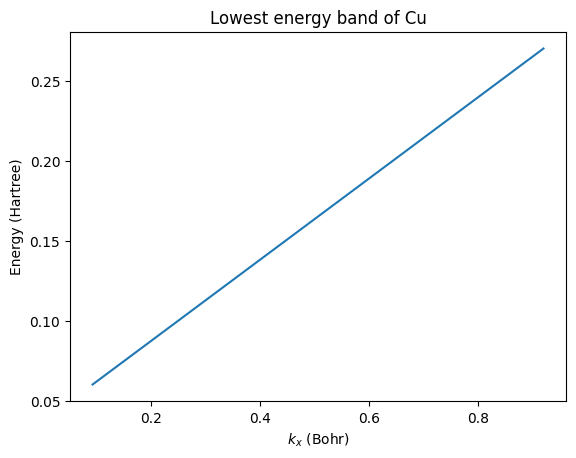

In [ ]:
plt.plot(list(map(lambda k: k[0],ks)),Es)
plt.title("Lowest energy band of Cu")
plt.xlabel(r"$k_x$ (Bohr)")
plt.ylabel("Energy (Hartree)")